# Partial wave analysis notebook
In the notebook I perform the mass-independent partial wave analysis in a single $m_{3\pi}$ bin.
 1. __Prepare data__: $M_{3\pi} \in [2.3, 2.31]\,$GeV
 Boost, rotate - extract complete set of kinematic variables:
 $$
 (s ,\quad \sigma_1,\quad \theta_{1},\quad \phi_{1},\quad \theta_{23},\quad \phi_{23})
 $$
 
 2. __Perpare Model__: 88 waves, coherence 
 $$
 \text{FLAT}\otimes(\epsilon=+)\otimes(\epsilon=-)\otimes(\epsilon=-)
 $$
 
 3. __Perform fit__: gradient based minimization in 186 dims using the extended likelihood method
 $$
  -LLH = \sum_e \log \left|c_i \Psi_i(e)\right|^2 + c_i \,B_{i,j} c_j^*
 $$

In [1]:
using JLD
using Plots

In [2]:
push!(LOAD_PATH,joinpath(pwd(),"src"))

3-element Array{Any,1}:
 "/home/mikhasenko/Tools/julia/usr/local/share/julia/site/v0.6"
 "/home/mikhasenko/Tools/julia/usr/share/julia/site/v0.6"      
 "/home/mikhasenko/Documents/pwa_from_scratch/src"             

In [3]:
using amplitudes_compass # code of the basis functions \Psi_i

## First step: data preparation

1. Prepare data: $M_{3\pi} \in [2.3, 2.31]\,$GeV
 Boost, rotate - extract complete set of kinematic variables:
 $$
 (s ,\quad \sigma_1,\quad \theta_{1},\quad \phi_{1},\quad \theta_{23},\quad \phi_{23})
 $$

Open `.root` trees with the data and calculate the variables for the every event

#### Compile
```bash
g++ -std=c++11 -o Extract Extract.C -I$(root-config --incdir) $(root-config --libs)
```
#### Get events from the REALDATA
```bash
./src/Extract data/2300_2320_rd.root D > data/2300_2320_rd.txt
./src/Extract data/2300_2320_mc.root M > data/2300_2320_mc.txt
./src/Extract data/2300_2320_mc.root F > data/2300_2320_fu.txt
```

In [5]:
let fl = open(joinpath("data","2300_2310_t1_rd.txt"))
    println("    s    sigma1   cosT1    phi1    cosT23    phi23")
    println("----------------------------------------------------")
    for i in 1:5
        println(readline(fl))
    end
end

    s    sigma1   cosT1    phi1    cosT23    phi23
----------------------------------------------------
5.32286 4.21723 0.891539 -2.57359 -0.809345 -0.124994
5.31343 0.657029 0.663781 1.08893 0.0156355 -0.159559
5.32833 3.08183 0.479433 -1.66379 -0.546917 -0.0635737
5.32333 0.629162 0.88872 -1.14885 -0.540153 -2.07393
5.31523 2.82132 0.898265 -1.10227 0.741922 -0.901394


### Precalculate basis functions on Data events and MC events
The basis functions are some complex functions of kinematical variables $\tau = s,(\sigma_1,\Omega_1,\Omega_{23})$.

In [4]:
function precalculate_compass_basis(fin,fout)
    mm = readdlm(fin)#[1:1000,:];
    m2 = [COMPASS_wave(i,mm[e,:]...) for e=1:size(mm,1), i=1:88];
    save(fout,"real",real(m2),"imag",imag(m2))
end
function read_precalc_basis(fname)
    ld = load(fname)
    ld["real"]+1im*ld["imag"]
end

read_precalc_basis (generic function with 1 method)

We calculate and save to the file the following matrix $N_\text{ev}\times 88$
$$
[\,\Psi_i(\tau_e)\,],\quad \forall i = 1,\dots,88,\quad e = 1,\dots,N_\text{ev}
$$

```julia
@time precalculate_compass_basis(joinpath("data","2300_2320_t1_rd.txt"), "rd.jld")  # 12 sec.
@time precalculate_compass_basis(joinpath("data","2300_2320_t1_mc.txt"), "mc.jld")  # 35 sec.
@time precalculate_compass_basis(joinpath("data","2300_2320_t1_fu.txt"), "fu.jld")  # 67 sec.
```

## Second step: Model preparation
Files contains the list of waves with $J$ $P$ $L$ $S$ classification

In [13]:
waves = readdlm(pwd()*"/src/wavelist_formated.txt");
wavenames

88-element Array{Any,1}:
 "flat"                
 "1-(1++)0+rhopiS"     
 "1-(0-+)0+(pipi)_SpiS"
 "1-(0-+)0+f0(980)piS" 
 "1-(0-+)0+rhopiP"     
 "1-(0-+)0+f0(1500)piS"
 "1-(0-+)0+f2piD"      
 "1-(1++)1+rhopiS"     
 "1-(1++)0+rhopiD"     
 "1-(1++)1+rhopiD"     
 "1-(1++)0+(pipi)_SpiP"
 "1-(1++)1+(pipi)_SpiP"
 "1-(1++)0+f2piP"      
 ⋮                     
 "1-(6-+)1+rhopiH"     
 "1-(6-+)0+rho3piF"    
 "1-(6-+)0+f2piG"      
 "1-(6++)1+rhopi6"     
 "1-(6++)1+f2piH"      
 "1-(1-+)0-rhopiP"     
 "1-(1-+)1-rhopiP"     
 "1-(1++)1-rhopiS"     
 "1-(2++)0-rhopiD"     
 "1-(2++)0-f2piP"      
 "1-(2++)1-f2piP"      
 "1-(2-+)1-f2piS"      

In [14]:
const noϵ = [i==1 for i=1:size(waves[:,6],1)]
const posϵ = [ϵ=="+" for ϵ in waves[:,6]]
const negϵ = [ϵ=="-" for ϵ in waves[:,6]];

In [23]:
const ModelBlocks = [noϵ,posϵ,negϵ,negϵ];

Coherence matrix has block-diagonal form
$$
\begin{pmatrix}
\text{FLAT} && &\\
&\epsilon = + & &\\
& &\epsilon = - &\\
& & &\epsilon = -\\
\end{pmatrix}
$$

### A bit of Lineal Algebra:
Naively, one would write the intensity as
$$
I = \left|\,\Psi_i c_i\,\right|^2
$$
We add more information to the model: some function are not allowed to interfer.
Particularly,
 * there are different reflectivities which do not interfere due to the proton helicity.
 * There is the FLAT wave to pick up phase space like background.
 * The corerent blocks might have different rank which essentially makes more non-interfering blocks.
 
Therefore, we introduce the index $\beta$ which numbers blocks
$$
I = \sum_{\epsilon}\left|\,\Psi_i^{\epsilon} c_i^{\epsilon}\,\right|^2 = \left|\,\Psi_i^{(\epsilon = 0)} c_i^{(\epsilon = 0)}\,\right|^2 + \left|\,\Psi_i^{(\epsilon = +)} c_i^{(\epsilon = +)}\,\right|^2 +\dots +\left|\,\Psi_i^{(\epsilon = -)} c_i^{(\epsilon = -)}\,\right|^2.
$$

Finally, the parameters suppose to be complex. All except the first one in the block to fix the overall phase for every block.


Still, the intensity can be written as a bilinear combination of the __real__ parameters $c_i$:
$$
I = c_i I_{ij}^* \Psi_j^* \left( \sum_\beta t_\beta t_\beta^T\right)_{jb} c_a I_{ab} \Psi_b,
$$
where the matrix $I_{ij}$ maps the basis functions to the real parameters, $t_\beta$ are vectors in the form 
$$
(0,\dots,0,\underbrace{1,1,\dots,1}_{\textrm{coherence block}},0,\dots,0)
$$
which make required coherence.


Below I code those function in the callback form based on the `ModelBlocks`-input:
 * `extend_psi(Psi)` does fast multiplication $I_{ij}\,\Psi_j$
 * `COHsq(X)` does fast bilinear contraction with the coherent matrix. Returns $X \,( \sum_\beta t_\beta t_\beta^T)\, X$
 * `COHts(X)` does fast oneside contraction with the coherent matrix. Returns $( \sum_\beta t_\beta t_\beta^T)\, X$

#### Map of parameters $I_{ij}$: real values $\to$ a certain basis function

In [24]:
function get_parameter_map(block_masks)
    temp = []; numb = []
    for (i,bl) in enumerate(ModelBlocks)
        # push false for the first parameter, true for others 
        push!(temp,false,[true for i=1:(sum(bl)-1)]...);
        push!(numb,collect(1:88)[bl]...)
    end
    Tmap = fill(0,2,sum(temp+1))
    count=1
    for (i,b) in enumerate(temp)
        Tmap[1,count] = numb[i]
        count+=1
        if b
            Tmap[2,count] = numb[i];
            count+=1
        end
    end
    Tmap
end
get_parameter_map([noϵ,posϵ,negϵ,negϵ])

2×186 Array{Int64,2}:
 1  2  3  0  4  0  5  0  6  0  7  0  8  …   0  85   0  86   0  87   0  88   0
 0  0  0  3  0  4  0  5  0  6  0  7  0     84   0  85   0  86   0  87   0  88

#### Coherent blocks in the real parameter space

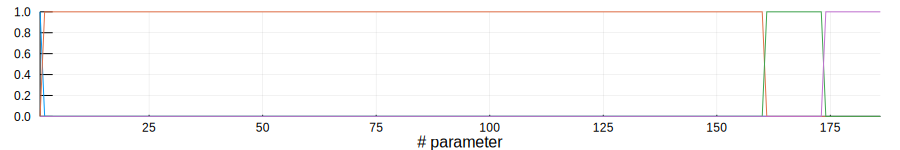

In [27]:
function make_pblock_masks(block_masks)
    just_true = [fill(true,2sum(bl)-1) for bl in block_masks]
    tmp = fill(false,sum(sum(jt) for jt in just_true))
    # to be filed
    pbls = copy(block_masks) 
    counter = 1
    for (i,jt) in enumerate(just_true)
        pbls[i] = copy(tmp)
        jtlen = length(jt)
        pbls[i][counter:(counter+jtlen-1)] .= true
        counter += jtlen
    end
    pbls
end
plot(make_pblock_masks(ModelBlocks), size=(900,150), xlab="# parameter", lab="")

Three functions returning callbacks adjusted to the model

In [28]:
const TMAP = get_parameter_map(ModelBlocks)
const NP = size(TMAP,2)
const PBLOCKS = make_pblock_masks(ModelBlocks)

EXTND(Ψ) = [((TMAP[2,i]==0) ? Ψ[TMAP[1,i]] : 1im*Ψ[TMAP[2,i]]) for i in 1:NP]

function COHSQ(X::Vector{Complex{Float64}})
    sum(abs2(sum(X[bl])) for bl in PBLOCKS)
end
function COHTS(X::Vector{Complex{Float64}})
    sum(sum(X[bl])*bl for bl in PBLOCKS)
end

COHTS (generic function with 1 method)

In [29]:
function contract_to_intensity(ΨΨstar, block_masks)
    Tmap = get_parameter_map(block_masks)
    Np = size(Tmap,2)
    pblocks = make_pblock_masks(block_masks)
    COH = sum(bl*bl' for bl in pblocks)
    get(v,w) = (v==0 || w==0) ? 0.0im : ΨΨstar[v,w]
    [COH[i,j]*( # meaning is ([1]-i[2]) * ([1]+i[2])
            get(Tmap[1,i],Tmap[1,j]) +
            get(Tmap[2,i],Tmap[2,j]) -
        1im*get(Tmap[2,i],Tmap[1,j]) +
        1im*get(Tmap[1,i],Tmap[2,j])
            ) for j in 1:Np, i in 1:Np]
end

contract_to_intensity (generic function with 1 method)

### The overlap integrals with experiment acceptance
those are calculated using the Monte Carlo ACCEPTED sample

$$
B_{ij} \quad = \quad \frac{1}{\Phi}\int \Psi_i^*(\tau)\,\Psi_h(\tau)\,\epsilon(\tau)\, \mathrm{d}\Phi_3
\quad\approx\quad
\frac{1}{N_\textrm{MC}^\textrm{ACCEPTED}} \sum_e^{N_\textrm{MC}^\textrm{ACCEPTED}} \Psi_i^*(\tau_e)\,\Psi_h(\tau_e)
$$

In [30]:
const PsiMC = read_precalc_basis("mc.jld"); # [1:1000,:];

In [31]:
@time sum_mat = [sum(PsiMC[e,i]'*PsiMC[e,j] for e in 1:size(PsiMC,1)) for i=1:88, j=1:88]/size(PsiMC,1);
# 2.135464 seconds (117.70 k allocations: 5.659 MiB)

  1.936233 seconds (62.49 k allocations: 2.987 MiB)


In [32]:
sum_mat_n = [sum_mat[i,j]/sqrt(sum_mat[i,i]*sum_mat[j,j]) for i=1:88, j=1:88];

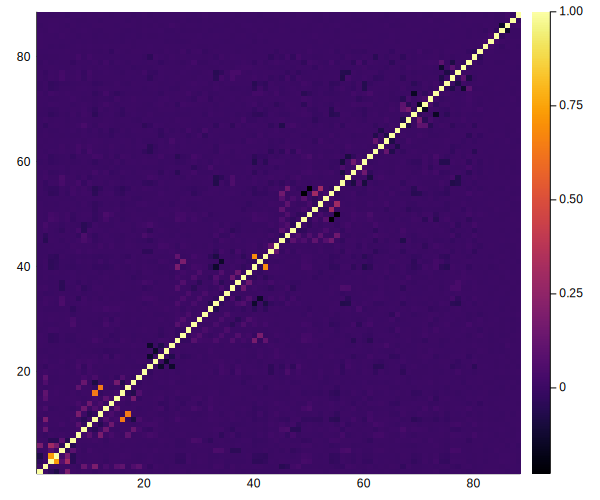

In [37]:
heatmap(real(sum_mat_n), size=(600,500))

In [38]:
const BM = real.(contract_to_intensity(sum_mat, ModelBlocks));

### Real data: construction of the Likelihood

In [39]:
const PsiRD = read_precalc_basis("rd.jld")#[1:10000,:]
const ND = size(PsiRD,1);

Likelihood functions

In [40]:
function LLH(pars)
    res = sum(log(COHSQ(EXTND(PsiRD[e,:]).*pars)) for e in 1:ND)
    - res + real(sum(pars[i]*BM[i,j]*pars[j] for i=1:length(pars), j=1:length(pars))) * ND
end

function GETDV(psi::Vector{Complex{Float64}}, pars::Vector{Float64})
    ExtΨ = EXTND(psi)
    cExtΨ = conj.(ExtΨ)
    cv = cExtΨ.*COHTS(ExtΨ.*pars)
    return real.(cv)
end

function LLH_and_GRAD!(pars, grad)
    val = 0.0; grad .= 0.0
    for e in 1:ND
        @inbounds v = GETDV(PsiRD[e,:],pars)
        vale = pars'*v
        grad .-= v / vale
        val -= log(vale);
    end
    grad .*= 2.0

    BB = BM*pars;
    val += pars'*BB * ND;
    grad .+= BB* (2ND);
    return val;
end

LLH_and_GRAD! (generic function with 1 method)

In [41]:
test_t = rand(186);

In [43]:
@time LLH(test_t)

  0.179141 seconds (289.33 k allocations: 139.008 MiB, 19.88% gc time)


4.496691603956659e6

In [45]:
@time @show LLH(test_t)
@time g1 = let gra = Vector{Float64}(186)
    v = LLH_and_GRAD!(test_t,gra)
    @show v
    gra
end

LLH(test_t) = 4.496691603956659e6
  0.244188 seconds (289.41 k allocations: 139.010 MiB, 23.32% gc time)
v = 4.49669160395667e6
  0.445394 seconds (403.54 k allocations: 517.072 MiB, 16.15% gc time)


186-element Array{Float64,1}:
   3632.01     
 336281.0      
  14361.4      
  92575.3      
  17750.7      
      1.50931e5
      2.84473e5
      4.53901e5
 -12884.9      
  12663.8      
   6797.72     
   5668.73     
      3.85086e5
      ⋮        
      1.09394e5
 271697.0      
      3.77558e5
      2.93298e5
      1.90089e5
      3.76239e5
   3920.34     
  -4324.83     
    804.527    
   2302.5      
   1112.05     
   3894.58     

In [46]:
using NLopt

In [47]:
function minimize(; verbose::Int=0, starting_pars::Vector{Float64} = rand(size(TT,2)))
    function to_minimize(x::Vector, grad::Vector)
        if length(grad) > 0
            v = LLH_and_GRAD!(x,grad)
        else
            v = LLH(x)
        end
        verbose==1 && @show v
        verbose==2 && @show v,x
        verbose==3 && @show v,grad
        return v;
    end
    opt = Opt(:LD_LBFGS, length(starting_pars)) # try LD_LBFGS || LD_MMA
    xtol_rel!(opt,1e-4)
    maxeval!(opt,500000)

    min_objective!(opt, to_minimize)

    (minf,pars,ret) = optimize(opt, starting_pars)#rand(size(TT,2)))
    println("got $minf at $pars = [m, Γ] after some iterations (returned $ret)")
    pars
end

minimize (generic function with 1 method)

In [33]:
# @time minpars = minimize(verbose=1, startpars=test_t)

In [48]:
# writedlm("min1e6.txt", minpars)
minpars0 = vcat(readdlm("minpars.txt")...);

In [65]:
@time minpars = minimize(verbose=1, starting_pars=rand(NP));

v = 3.295913927168815e6
v = 3.9218060528106323e17
v = 3.91967228399647e13
v = 3.709476964856836e9
v = 356370.4150899539
v = 184882.27117733133
v = 105538.44134389155
v = 74926.75640815416
v = 55006.298930552926
v = 38716.45681453053
v = 23820.19412647906
v = 18004.381399942045
v = 13724.972588204871
v = 11343.705256109246
v = 8521.48450856207
v = 5173.797905291756
v = 3236.292396288165
v = 2060.599870703658
v = 1609.8906118271607
v = 1146.4459116012367
v = 710.4730498964509
v = 259.90133981206964
v = -102.09583165685035
v = -347.4166163393238
v = -481.85414278638746
v = -668.4782166290497
v = -858.7867879524438
v = -1087.1715693492697
v = -1279.5370421247662
v = -1436.4593221039759
v = -1500.554343031581
v = -1601.3700867400075
v = -1739.6375063730102
v = -1827.9394257325675
v = -1919.951843171786
v = -1963.4797688281942
v = -2010.4144286632018
v = -2065.785728114397
v = -2115.0237456734903
v = -2157.917167902897
v = -2198.260256503081
v = -2235.420339414315
v = -2261.415373383579
v = 

## Compare disributions

In [55]:
const MC1 = readdlm(joinpath("data","2300_2320_t1_mc.txt"));

In [57]:
@time const MC3 = hcat([swap_kin_parameters(MC1[e,:]...) for e in 1:size(MC1,1)]...)';

  1.732179 seconds (5.24 M allocations: 183.550 MiB, 12.41% gc time)


In [58]:
COMPASS_wave(5,MC1[1,:]...)-COMPASS_wave(5,MC3[1,:]...)

0.0 + 0.0im

In [59]:
@time weights = let mpars = minpars
    [COHSQ(EXTND(PsiMC[i,:]).*mpars) for i in 1:size(PsiMC,1)];
    end;

  0.809071 seconds (1.67 M allocations: 796.050 MiB, 17.50% gc time)


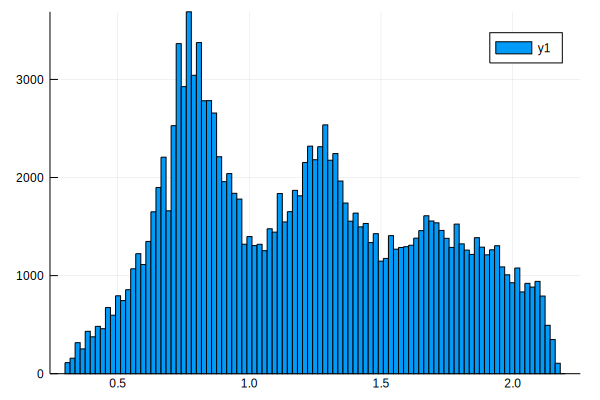

In [60]:
histogram(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights), bins=(linspace(0.3,2.2,100)))

In [66]:
const DT1 = readdlm(joinpath("data","2300_2320_t1_rd.txt"));

In [68]:
@time const DT3 = hcat([swap_kin_parameters(DT1[e,:]...) for e in 1:size(DT1,1)]...)';

  0.194185 seconds (743.83 k allocations: 25.692 MiB, 21.90% gc time)


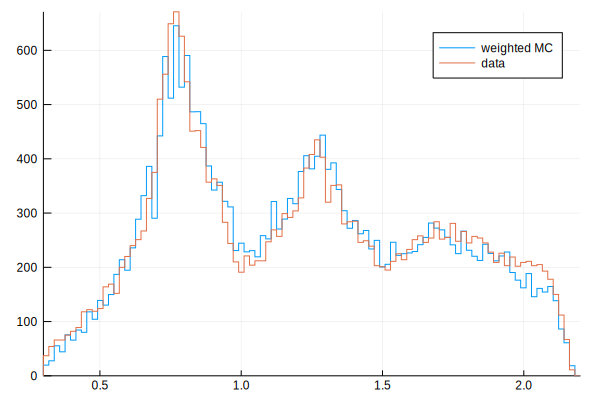

In [69]:
stephist(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(0.3,2.2,100),lab="weighted MC")
stephist!(sqrt.(vcat(DT1[:,2],DT3[:,2])), bins=linspace(0.3,2.2,100),lab="data") 

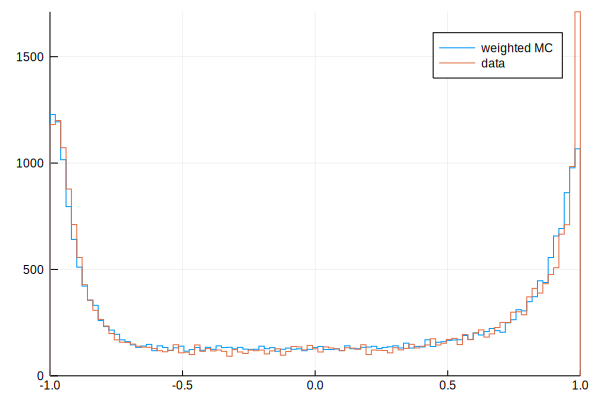

In [70]:
stephist(vcat(MC1[:,3],MC3[:,3]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-1,1,100),lab="weighted MC")
stephist!(vcat(DT1[:,3],DT3[:,3]), bins=linspace(-1,1,100),lab="data") 

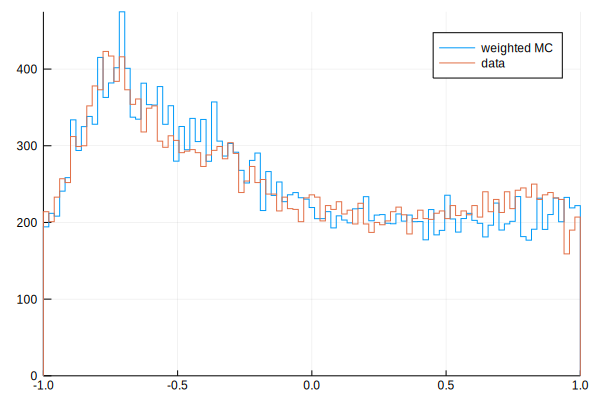

In [71]:
stephist(vcat(MC1[:,5],MC3[:,5]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-1,1,100),lab="weighted MC")
stephist!(vcat(DT1[:,5],DT3[:,5]), bins=linspace(-1,1,100),lab="data") 

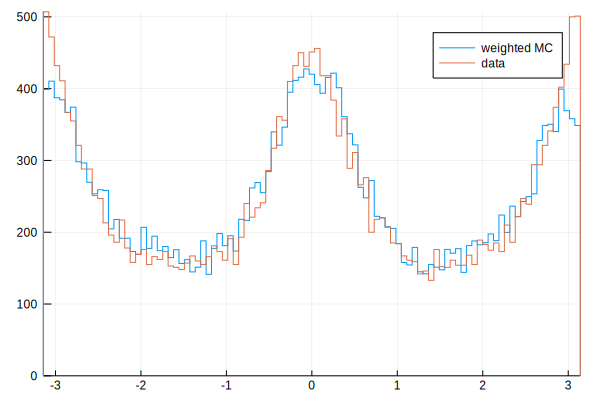

In [72]:
stephist(vcat(MC1[:,6],MC3[:,6]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-π,π,100),lab="weighted MC")
stephist!(vcat(DT1[:,6],DT3[:,6]), bins=linspace(-π,π,100),lab="data") 

### Plot individual components

In [73]:
isobars = [[w==p for w in waves[:,7]] for p in -2:3];
push!(isobars,vcat([true],fill(false,88-1)));

In [74]:
@time weightsI = let mpars = minpars, isom = isobars
    [[COHSQ(EXTND(PsiMC[i,:].*isom[p]).*mpars) for i in 1:size(PsiMC,1)] for p in 1:size(isom,1)];
end;
# 21.613377 seconds (72.37 M allocations: 36.675 GiB, 17.39% gc time)

  5.546319 seconds (12.15 M allocations: 6.139 GiB, 18.05% gc time)


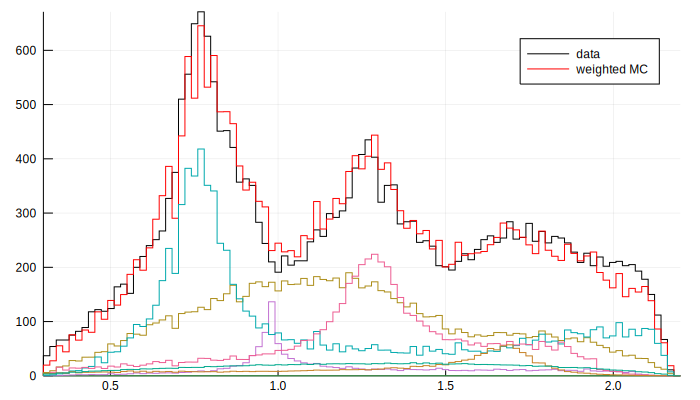

In [75]:
stephist( sqrt.(vcat(DT1[:,2],DT3[:,2])), bins=linspace(0.3,2.2,100),lab="data",lc=:black) 
stephist!(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(0.3,2.2,100),lab="weighted MC",lc=:red)
for p in 1:size(isobars,1)
    stephist!(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weightsI[p],weightsI[p])/size(MC1,1)*size(DT1,1),
        bins=linspace(0.3,2.2,100),lab="")
end
plot!(size=(700,400))

In [83]:
[println(rpad("S = $(i-3) ",7), ":   ", round(sum(weightsI[i])/size(MC1,1)*size(DT1,1),3)) for i in 1:7];

S = -2 :   0.069
S = -1 :   640.179
S = 0  :   4781.917
S = 1  :   4234.585
S = 2  :   2673.313
S = 3  :   634.482
S = 4  :   791.431
